In [1]:
# Функция для расчета скользящих средних
def calculate_moving_averages(data, window):
    data['SMA_' + str(window)] = data['Цена'].rolling(window=window).mean()  # Простое скользящее среднее
    data['EMA_' + str(window)] = data['Цена'].ewm(span=window, adjust=False).mean()  # Экспоненциальное скользящее среднее
    return data

# Функция для расчета RSI
def calculate_rsi(data, window=14):
    delta = data['Цена'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

# Функция для расчета MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Цена'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Цена'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, -1])  # Assuming 'Цена' is the last column
    return np.array(dataX), np.array(dataY)

In [2]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Загрузка данных
data_lkoh = pd.read_csv('data/Прошлые данные - LKOH.csv')
# Убираем суффиксы "K" из столбца "Объём"
data_lkoh['Объём'] = data_lkoh['Объём'].str.replace('M', '000000').str.replace('K', '000')

data_lkoh['Изм. %'] = data_lkoh['Изм. %'].str.replace('%', '')

# Преобразование типов данных с учетом разделителей тысяч и возможных десятичных запятых
data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])
data_lkoh['Цена'] = pd.to_numeric(data_lkoh['Цена'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Откр.'] = pd.to_numeric(data_lkoh['Откр.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Макс.'] = pd.to_numeric(data_lkoh['Макс.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Мин.'] = pd.to_numeric(data_lkoh['Мин.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Объём'] = pd.to_numeric(data_lkoh['Объём'].str.replace('.', '').str.replace(',', ''))
data_lkoh['Изм. %'] = pd.to_numeric(data_lkoh['Изм. %'].str.replace(',', '.'))

C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
C:\Users\User\AppData\Local\Temp\ipykernel_13608\2972790018.py:22: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])


In [3]:
df = data_lkoh
df['dayofweek'] = df['Дата'].dt.dayofweek
df['quarter'] = df['Дата'].dt.quarter
df['month'] = df['Дата'].dt.month
df['year'] = df['Дата'].dt.year
df['dayofyear'] = df['Дата'].dt.dayofyear
df['dayofmonth'] = df['Дата'].dt.day
df['weekofyear'] = df['Дата'].dt.isocalendar().week
# Выберите начальную дату (например, первая дата в вашем наборе данных)
start_date = data_lkoh['Дата'].min()

# Рассчитайте количество дней от начальной даты для каждой строки
data_lkoh['timestamp'] = (data_lkoh['Дата'] - start_date).dt.days


In [4]:
# Расчет признаков
data_lkoh = calculate_moving_averages(data_lkoh, window=20)  # Пример: 20-дневные скользящие средние
data_lkoh = calculate_rsi(data_lkoh)
data_lkoh = calculate_macd(data_lkoh)
# Interpolate missing values for 'RSI' and 'SMA_20' columns
data_lkoh['RSI'].interpolate(inplace=True)
data_lkoh['SMA_20'].interpolate(inplace=True)

# Check for remaining missing values
missing_values = data_lkoh.isnull().sum()
missing_values

Дата            0
Цена            0
Откр.           0
Макс.           0
Мин.            0
Объём           0
Изм. %          0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
weekofyear      0
timestamp       0
SMA_20         19
EMA_20          0
RSI            13
MACD            0
Signal_Line     0
dtype: int64

In [5]:
data_lkoh = data_lkoh.sort_index(ascending=False)
data_lkoh = data_lkoh.reset_index(drop=True)
data_lkoh

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,timestamp,SMA_20,EMA_20,RSI,MACD,Signal_Line
0,2013-01-14,2020.0,2010.9,2021.4,2001.9,117000000,0.69,0,1,1,2013,14,14,3,0,2006.070,2004.281941,51.827243,5.544697,5.470472
1,2013-01-15,2006.0,2018.3,2018.6,2000.2,55997000,-0.69,1,1,1,2013,15,15,3,1,2004.785,2002.627408,49.582754,4.699511,5.451916
2,2013-01-16,2007.6,2006.5,2011.0,1990.5,70856000,0.08,2,1,1,2013,16,16,3,2,2003.990,2002.272398,47.187293,4.977845,5.640017
3,2013-01-17,2012.7,2013.3,2020.0,1996.0,94260000,0.25,3,1,1,2013,17,17,3,3,2004.120,2001.711598,52.541296,5.097786,5.805560
4,2013-01-18,2017.0,2016.0,2022.0,2012.4,65519000,0.21,4,1,1,2013,18,18,3,4,2003.735,2000.554924,55.273189,4.657452,5.982504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,2023-10-09,6863.5,6880.0,6895.5,6822.0,111000000,0.98,0,4,10,2023,282,9,41,3920,NaN,7137.807524,NaN,-75.158655,-30.024858
2690,2023-10-10,6853.5,6874.0,6880.0,6822.5,55220000,-0.15,1,4,10,2023,283,10,41,3921,NaN,7166.682000,NaN,-58.707016,-18.741408
2691,2023-10-11,6890.5,6864.5,7099.5,6835.5,347000000,0.54,2,4,10,2023,284,11,41,3922,NaN,7199.648526,NaN,-35.836641,-8.750006
2692,2023-10-12,7120.0,6862.5,7154.0,6848.0,272000000,3.33,3,4,10,2023,285,12,41,3923,NaN,7232.190476,NaN,-9.891738,-1.978348


In [150]:
# Сдвигаем цену на следующий день
data_lkoh['Цена'] = data_lkoh['Цена'].shift(-1)

# Удаляем последнюю строку, так как у нее не будет цены на следующий день
data_lkoh.dropna(inplace=True)

# Посмотрим на обновленный датасет
print(data_lkoh.head())


        Дата    Цена   Откр.   Макс.    Мин.      Объём  Изм. %  dayofweek  \
0 2013-01-14  2006.0  2010.9  2021.4  2001.9  117000000    0.69          0   
1 2013-01-15  2007.6  2018.3  2018.6  2000.2   55997000   -0.69          1   
2 2013-01-16  2012.7  2006.5  2011.0  1990.5   70856000    0.08          2   
3 2013-01-17  2017.0  2013.3  2020.0  1996.0   94260000    0.25          3   
4 2013-01-18  2003.0  2016.0  2022.0  2012.4   65519000    0.21          4   

   quarter  month  year  dayofyear  dayofmonth  weekofyear  timestamp  \
0        1      1  2013         14          14           3          0   
1        1      1  2013         15          15           3          1   
2        1      1  2013         16          16           3          2   
3        1      1  2013         17          17           3          3   
4        1      1  2013         18          18           3          4   

     SMA_20       EMA_20        RSI      MACD  Signal_Line  
0  2006.070  2004.281941  51.82

In [6]:
train_size = int(len(data_lkoh) * 0.8)
scaler = MinMaxScaler(feature_range=(0,1))
data = data_lkoh[['Цена']]
data['Цена'] = scaler.fit_transform(data['Цена'].values.reshape(-1, 1))
time_steps = 300
X_ltsm, y = create_dataset(data.values, time_steps)

# Split into train and test sets
X_train_LTSM, X_test_LTSM = X_ltsm[:train_size], X_ltsm[train_size:]
y_train_LTSM, y_test_LTSM = y[:train_size], y[train_size:]
print(len(X_train_LTSM))

2155


C:\Users\User\AppData\Local\Temp\ipykernel_13608\3307076803.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Цена'] = scaler.fit_transform(data['Цена'].values.reshape(-1, 1))


In [11]:
X_train_LTSM.shape

(2155, 300, 1)

In [12]:

model = Sequential()
# 1st lstm layer
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train_LTSM.shape[1], 1)))
model.add(Dropout(0.2))
# 2st lstm layer
model.add(LSTM(units=100,return_sequences=False))
model.add(Dropout(0.2))
# 3st lstm layer
# model.add(LSTM(units=100,return_sequences=False))
# model.add(Dropout(0.2))
# 4st lstm layer 
# model.add(LSTM(units=100,return_sequences= False))
# model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mae')
# train the model
history = model.fit(X_train_LTSM, y_train_LTSM, epochs=2, batch_size=128, validation_data=(X_test_LTSM, y_test_LTSM))


Epoch 1/2
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13608\3054127377.py", line 17, in <module>
    history = model.fit(X_train_LTSM, y_train_LTSM, epochs=2, batch_size=16, validation_data=(X_test_LTSM, y_test_LTSM))
  File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\tensorflow\python\eager\execute.py", line 54, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'sequential/dense/MatMul' defined at (most recent call last):
    File "C:\Users\U

In [28]:
# predictions_LTSM_test = model.predict(X_test_LTSM)

In [115]:
predictions_LTSM_train = model.predict(X_train_LTSM)

67/67 [==============================] - 10s 133ms/step


In [116]:
predictions_LTSM_train

array([[0.00916915],
       [0.00928199],
       [0.00957688],
       ...,
       [0.38691163],
       [0.39061224],
       [0.39502883]], dtype=float32)

In [113]:
y_train_LTSM

array([0.02318876, 0.0212431 , 0.0199342 , ..., 0.41762771, 0.42408377,
       0.41585892])

In [52]:
# Получите последние точки данных для создания начальных условий
initial_conditions = X_train_LTSM[-1]  # Берем последние точки данных из обучающей выборки

# Количество шагов вперед для предсказания
steps_forward = 234  # Измените на нужное количество шагов вперед

predictions_future = []

for _ in range(steps_forward):
    # Предсказываем следующее значение
    next_prediction = model.predict(np.array([initial_conditions]))  # Передаем последние точки данных

    # Добавляем предсказанное значение в начальные условия
    initial_conditions = np.concatenate((initial_conditions[1:], next_prediction), axis=0)

    # Добавляем предсказанное значение в список предсказаний
    predictions_future.append(next_prediction)

# predictions_future содержит предсказания на указанное количество шагов вперед


1/1 [==============================] - 0s 97ms/step


KeyboardInterrupt: 

In [89]:
y_train_LTSM

array([0.02318876, 0.0212431 , 0.0199342 , ..., 0.41762771, 0.42408377,
       0.41585892])

In [90]:
y_test_LTSM

array([0.42885949, 0.43372365, 0.42744446, 0.45857507, 0.46786119,
       0.4690109 , 0.49200509, 0.49978775, 0.51933281, 0.51517617,
       0.51429178, 0.51508773, 0.50978138, 0.51278831, 0.51924438,
       0.51464554, 0.50306   , 0.51172704, 0.50978138, 0.50774728,
       0.49120914, 0.50827791, 0.50111433, 0.50146809, 0.49837272,
       0.5005837 , 0.51137328, 0.50872011, 0.5096045 , 0.50164497,
       0.49775364, 0.49996462, 0.49731145, 0.49342012, 0.50076058,
       0.49801896, 0.4960733 , 0.49350856, 0.49439295, 0.49448139,
       0.49342012, 0.49571954, 0.48342649, 0.49386232, 0.50182185,
       0.40471558, 0.39843639, 0.39613697, 0.39313004, 0.3930416 ,
       0.39631385, 0.39401443, 0.39516414, 0.40356587, 0.41311731,
       0.41179072, 0.40666124, 0.407015  , 0.41072945, 0.40524621,
       0.40728032, 0.40515778, 0.40436182, 0.4004705 , 0.39569478,
       0.39498726, 0.38791213, 0.38136762, 0.38640866, 0.38110231,
       0.37774162, 0.37553064, 0.37659191, 0.3819867 , 0.38331

In [175]:
initial_actual_price = X_train_LTSM[-1]
initial_conditions = X_train_LTSM[-1]  # Берем последние точки данных из обучающей выборки
# Переменная для хранения текущей цены (фактической)
current_price = initial_actual_price  # Замените на фактическую цену первого дня

# Переменная для хранения предсказанной цены
predicted_price = initial_actual_price  # Инициализируем предсказанную цену значением фактической цены первого дня

# Количество дней для торговли
num_days = 100  # Замените на нужное количество дней
data = {
    'predicted_price': predicted_price.flatten()  # Распрямляем предсказанные значения, если нужно
}
predicted_price_df = pd.DataFrame(columns=['predicted_price'])  # Создаем пустой DataFrame с колонкой 'predicted_price'
X_train_LTSM_models = X_train_LTSM

# Переменные для хранения количества акций и наличных средств
num_shares = 100
cash = 1000000

# Цикл по дням
for day in range(num_days):
    predicted_price = model.predict(np.array([initial_conditions]))
    # Добавляем предсказанное значение в начальные условия
    initial_conditions = np.concatenate((initial_conditions[1:], predicted_price), axis=0)

    current_price = np.array([y_test_LTSM[day]])  # Замените на фактическую цену текущего дня

    # Обновление последней точки данных
    updated_last_point = np.concatenate((initial_conditions[-1][1:], np.array([current_price[0]])), axis=0)
    initial_conditions[-1] = updated_last_point
    predicted_price_df = pd.concat([predicted_price_df, pd.DataFrame({'predicted_price': [predicted_price.flatten()[0]]})], ignore_index=True)
    
    
    # Предсказание с XGBoost
    # Выберите строку для текущего дня из X_test и преобразуйте её в DataFrame
    zxc = pd.DataFrame(X_test.iloc[day]).transpose()
    xgb_predictions_test = model_xgb.predict(zxc)
    rf_predictions_test = model_rf.predict(zxc)
    # Инвертируем преобразование
    predictions_inverted = scaler.inverse_transform(predicted_price.reshape(-1, 1))
    ensemble_features_test = np.column_stack(( np.squeeze(predictions_inverted),xgb_predictions_test, rf_predictions_test))
    xgboost_ensemble_model_pred = xgboost_ensemble_model.predict(ensemble_features_test)
    print(xgboost_ensemble_model_pred)
    predicted_price = xgboost_ensemble_model_pred
    y_test = pd.DataFrame(y_test)
    y_test = y_test.reset_index(drop=True)
    
    current_price = y_test['Цена'][day]
    # Вывод текущей и предсказанной цен
    print(f"Current Price: {current_price}, Predicted Price: {predicted_price.flatten()[0]}")

    # Алгоритм покупки и продажи акций
    if current_price < predicted_price.flatten()[0]:
        # Покупаем 1 акцию
        if cash >= current_price:
            num_shares += 1
            cash -= current_price
            print("Bought 1 share")
    elif current_price > predicted_price.flatten()[0]:
        # Продаем 1 акцию
        if num_shares >= 1:
            num_shares -= 1
            cash += current_price
            print("Sold 1 share")

# Вывод количества акций и наличных средств после торговли
print(f"Final number of shares: {num_shares}")
print(f"Final cash balance: {cash}")

1/1 [==============================] - 0s 73ms/step
Sold 1 share
1/1 [==============================] - 0s 94ms/step
Bought 1 share
1/1 [==============================] - 0s 85ms/step
Sold 1 share
1/1 [==============================] - 0s 88ms/step
Sold 1 share
1/1 [==============================] - 0s 89ms/step
Bought 1 share
1/1 [==============================] - 0s 87ms/step
Sold 1 share
1/1 [==============================] - 0s 85ms/step
Sold 1 share
1/1 [==============================] - 0s 81ms/step
Sold 1 share
1/1 [==============================] - 0s 83ms/step
Sold 1 share
1/1 [==============================] - 0s 80ms/step
Sold 1 share
1/1 [==============================] - 0s 79ms/step
Sold 1 share
1/1 [==============================] - 0s 84ms/step
Sold 1 share
1/1 [==============================] - 0s 86ms/step
Sold 1 share
1/1 [==============================] - 0s 90ms/step
Sold 1 share
1/1 [==============================] - 0s 87ms/step
Sold 1 share
1/1 [================

4204.5

In [168]:
y_test

,Цена
2441,4240.0
2442,4204.5
2443,4380.5
2444,4433.0
2445,4439.5
...,...
2670,6610.0
2671,6519.0
2672,6553.0
2673,6526.0


In [143]:
initial_conditions = X_train_LTSM[-1]  # Берем последние точки данных из обучающей выборки
initial_conditions

array([[0.84514292],
       [0.82117589],
       [0.80905971],
       [0.785358  ],
       [0.79941984],
       [0.81454295],
       [0.82568629],
       [0.82170652],
       [0.81666549],
       [0.8038418 ],
       [0.81843427],
       [0.81861115],
       [0.79791637],
       [0.79950828],
       [0.79756261],
       [0.78659615],
       [0.80021579],
       [0.78677303],
       [0.79632447],
       [0.81993774],
       [0.82462502],
       [0.83426489],
       [0.82099901],
       [0.83267299],
       [0.84540824],
       [0.82374063],
       [0.80375336],
       [0.80507995],
       [0.82913542],
       [0.8313464 ],
       [0.82126433],
       [0.80578746],
       [0.82099901],
       [0.82267935],
       [0.79517476],
       [0.80410712],
       [0.80702561],
       [0.8033996 ],
       [0.80251521],
       [0.79455568],
       [0.80543371],
       [0.79269846],
       [0.79809325],
       [0.8194071 ],
       [0.84585043],
       [0.87317815],
       [0.86247701],
       [0.851

In [132]:
# Соединим все прогнозы в один массив
predictions_flat = np.array(predicted_price_df).flatten()

# Инвертируем преобразование
predictions_inverted = scaler.inverse_transform(predictions_flat.reshape(-1, 1))

# Изменим форму массива на ожидаемую
predictions_inverted = predictions_inverted.reshape(-1, steps_forward)

predictions_inverted = predictions_inverted.transpose()
predictions_LTSM_test = predictions_inverted


In [133]:

# Inverse transform the predictions
y_test_LTSM = scaler.inverse_transform(y_test_LTSM.reshape(-1, 1))
# Calculate metrics
mse = mean_squared_error(y_test_LTSM, predictions_LTSM_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_LTSM, predictions_LTSM_test)

print('RMSE (Root Mean Squared Error):', rmse)
print('R2 (Coefficient of Determination):', r2)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Вычисляем MAPE
mape = calculate_mape(y_test_LTSM, predictions_LTSM_test)
print('MAPE (Mean Absolute Percentage Error):', mape)


RMSE (Root Mean Squared Error): 202.55781724551053
R2 (Coefficient of Determination): 0.939996688907109
MAPE (Mean Absolute Percentage Error): 2.959410534666259


In [134]:
initial_conditions = X_train_LTSM[-time_steps:]
initial_conditions

array([[[0.53967384],
        [0.53843569],
        [0.55002123],
        ...,
        [0.85310245],
        [0.85770129],
        [0.84514292]],

       [[0.53843569],
        [0.55002123],
        [0.53613627],
        ...,
        [0.85770129],
        [0.84514292],
        [0.82117589]],

       [[0.55002123],
        [0.53613627],
        [0.54515707],
        ...,
        [0.84514292],
        [0.82117589],
        [0.80905971]],

       ...,

       [[0.85310245],
        [0.85770129],
        [0.84514292],
        ...,
        [0.36916301],
        [0.39746356],
        [0.42134215]],

       [[0.85770129],
        [0.84514292],
        [0.82117589],
        ...,
        [0.39746356],
        [0.42134215],
        [0.41762771]],

       [[0.84514292],
        [0.82117589],
        [0.80905971],
        ...,
        [0.42134215],
        [0.41762771],
        [0.42408377]]])

In [135]:
predictions_future

[array([[0.43529263]], dtype=float32),
 array([[0.43745768]], dtype=float32),
 array([[0.44046095]], dtype=float32),
 array([[0.4441324]], dtype=float32),
 array([[0.4483002]], dtype=float32),
 array([[0.45281646]], dtype=float32),
 array([[0.4575636]], dtype=float32),
 array([[0.46245718]], dtype=float32)]

In [136]:

# # Подготовка данных для XGBoost
# X = data_lkoh[[ 'dayofweek', 'quarter', 'month', 'year',
#                 'dayofyear', 'dayofmonth', 'weekofyear','timestamp',]]
X = data_lkoh.drop(['Цена','Дата'],axis=1)
y = data_lkoh['Цена']  # Целевая переменная


X = X[-len(X_ltsm):]
y = y[-len(X_ltsm):]


# Разделение данных на обучающую и тестовую выборки
X_train,X_test = X[:train_size], X[train_size:]
y_train,y_test = y[:train_size], y[train_size:]

# Убедитесь, что X_test и X_test_lstm имеют одинаковое количество строк

# Убедитесь, что y_test и y_test_lstm имеют одинаковое количество строк

In [137]:

# Создание и обучение модели XGBoost
model_xgb = xgb.XGBRegressor(max_depth=30, n_estimators=500)  # Подберите параметры по необходимости
model_xgb.fit(X_train, y_train)

# Прогнозирование
xgb_predictions_test = model_xgb.predict(X_test)
xgb_predictions_train = model_xgb.predict(X_train)

# Рассчет метрик
mse = mean_squared_error(y_test, xgb_predictions_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgb_predictions_test)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

# Create and train the Random Forest model
model_rf = RandomForestRegressor(max_depth=30, n_estimators=100)  # Adjust the parameters as needed
model_rf.fit(X_train, y_train)

# Predict
rf_predictions_test = model_rf.predict(X_test)
rf_predictions_train = model_rf.predict(X_train)

# Calculate metrics
mse = mean_squared_error(y_test, rf_predictions_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, rf_predictions_test)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

RMSE (Root Mean Squared Error): 99.59760389580335
r2 (Root Mean Squared Error): 0.9856454378610782
RMSE (Root Mean Squared Error): 84.52856363940046
r2 (Root Mean Squared Error): 0.9896605092884373


In [138]:
print(xgb_predictions_train.shape)
print(predictions_LTSM_train.shape)
print(rf_predictions_train.shape)

print(xgb_predictions_test.shape)
print(predictions_LTSM_test.shape)
print(rf_predictions_test.shape)


(2140,)
(2140, 1)
(2140,)
(234,)
(234, 1)
(234,)


In [139]:
import numpy as np

ensemble_features_train = np.column_stack(( np.squeeze(predictions_LTSM_train),xgb_predictions_train, rf_predictions_train))
ensemble_features_test = np.column_stack(( np.squeeze(predictions_LTSM_test),xgb_predictions_test, rf_predictions_test))

xgboost_ensemble_model = xgb.XGBRegressor(max_depth=50, n_estimators=1500)
xgboost_ensemble_model.fit(ensemble_features_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [140]:

# Обучение ансамбля (например, XGBoost) на объединенных прогнозах
# ensemble_model = xgb.XGBRegressor(max_depth=50, n_estimators=1500)
# ensemble_model.fit(ensemble_features_test, y_test)
# 
# # Получение прогнозов от ансамбля
# ensemble_predictions = ensemble_model.predict(ensemble_features_test)
# 
# # Рассчет метрик
# mse = mean_squared_error(y_test, ensemble_predictions)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, ensemble_predictions)
# 
# print('RMSE (Root Mean Squared Error):', rmse)
# print('r2 (Root Mean Squared Error):', r2)
# # Plot feature importance
# xgb.plot_importance(ensemble_model)
# plt.show()

In [141]:
xgboost_ensemble_model_pred = xgboost_ensemble_model.predict(ensemble_features_test)

# Рассчет метрик
mse = mean_squared_error(y_test, xgboost_ensemble_model_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgboost_ensemble_model_pred)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

RMSE (Root Mean Squared Error): 105.61854082560663
r2 (Root Mean Squared Error): 0.983857436803424


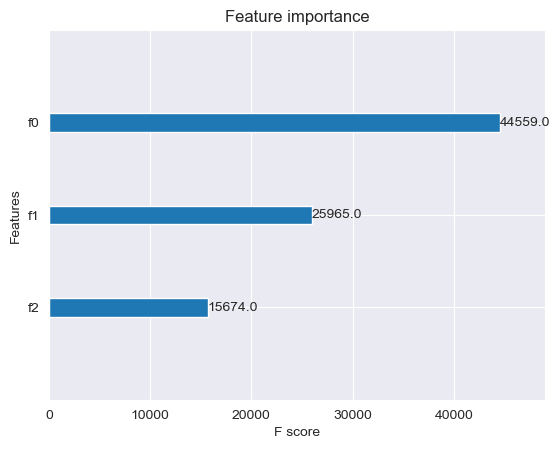

In [68]:
# Plot feature importance
xgb.plot_importance(xgboost_ensemble_model)
plt.show()

In [176]:
import numpy as np

# Инициализация переменных
max_profit = 0
total_profit = 0
trades = []

# Определение сигналов на покупку, продажу и удержание
signals = np.zeros_like(xgboost_ensemble_model_pred)
signals[1:] = (xgboost_ensemble_model_pred[1:] > y_test.values[:-1]) * 1  # Сигнал на покупку
signals[1:] += (xgboost_ensemble_model_pred[1:] < y_test.values[:-1]) * -1  # Сигнал на продажу

# Оценка производительности стратегии
portfolio_value = 0
cash = portfolio_value
position = 0
for i in range(len(xgboost_ensemble_model_pred) - 1):  # Итерируемся до предпоследнего периода
    current_price = y_test.values[i]
    next_price = y_test.values[i + 1]

    if signals[i] == 1 and next_price > current_price:  # Buy signal и предсказание роста
        afford_shares = int(cash / current_price)
        position += afford_shares
        cash -= afford_shares * current_price

    elif signals[i] == -1:  # Sell signal
        cash += position * current_price
        trade_profit = (position * current_price) - (afford_shares * current_price)
        total_profit += trade_profit

        if trade_profit > max_profit:
            max_profit = trade_profit
            max_profit_trade = (y_test.index[i], current_price, trade_profit)

        trades.append((y_test.index[i], current_price, trade_profit))

        position = 0

# Рассчитываем конечное состояние портфеля (учитывая последнюю позицию)
portfolio_value_final = cash + position * y_test.values[-1]

# Оцениваем производительность стратегии
returns = (portfolio_value_final - portfolio_value) / portfolio_value * 100.0

# Вывод информации о самых прибыльных сделках
print('Информация о самых прибыльных сделках:')
print('Date\t\t\tPrice at Sale\tProfit')
for trade in trades:
    print(f'{trade[0]}\t{trade[1]}\t{trade[2]:.2f}')

# Оценка производительности стратегии
total_trades = len(trades)
total_profit = sum(trade[2] for trade in trades)
average_profit_per_trade = total_profit / total_trades

print('Total number of trades:', total_trades)
print('Total profit (or loss) from all trades:', total_profit)
print('Average profit (or loss) per trade:', average_profit_per_trade)


ValueError: could not broadcast input array from shape (233,0) into shape (0,)

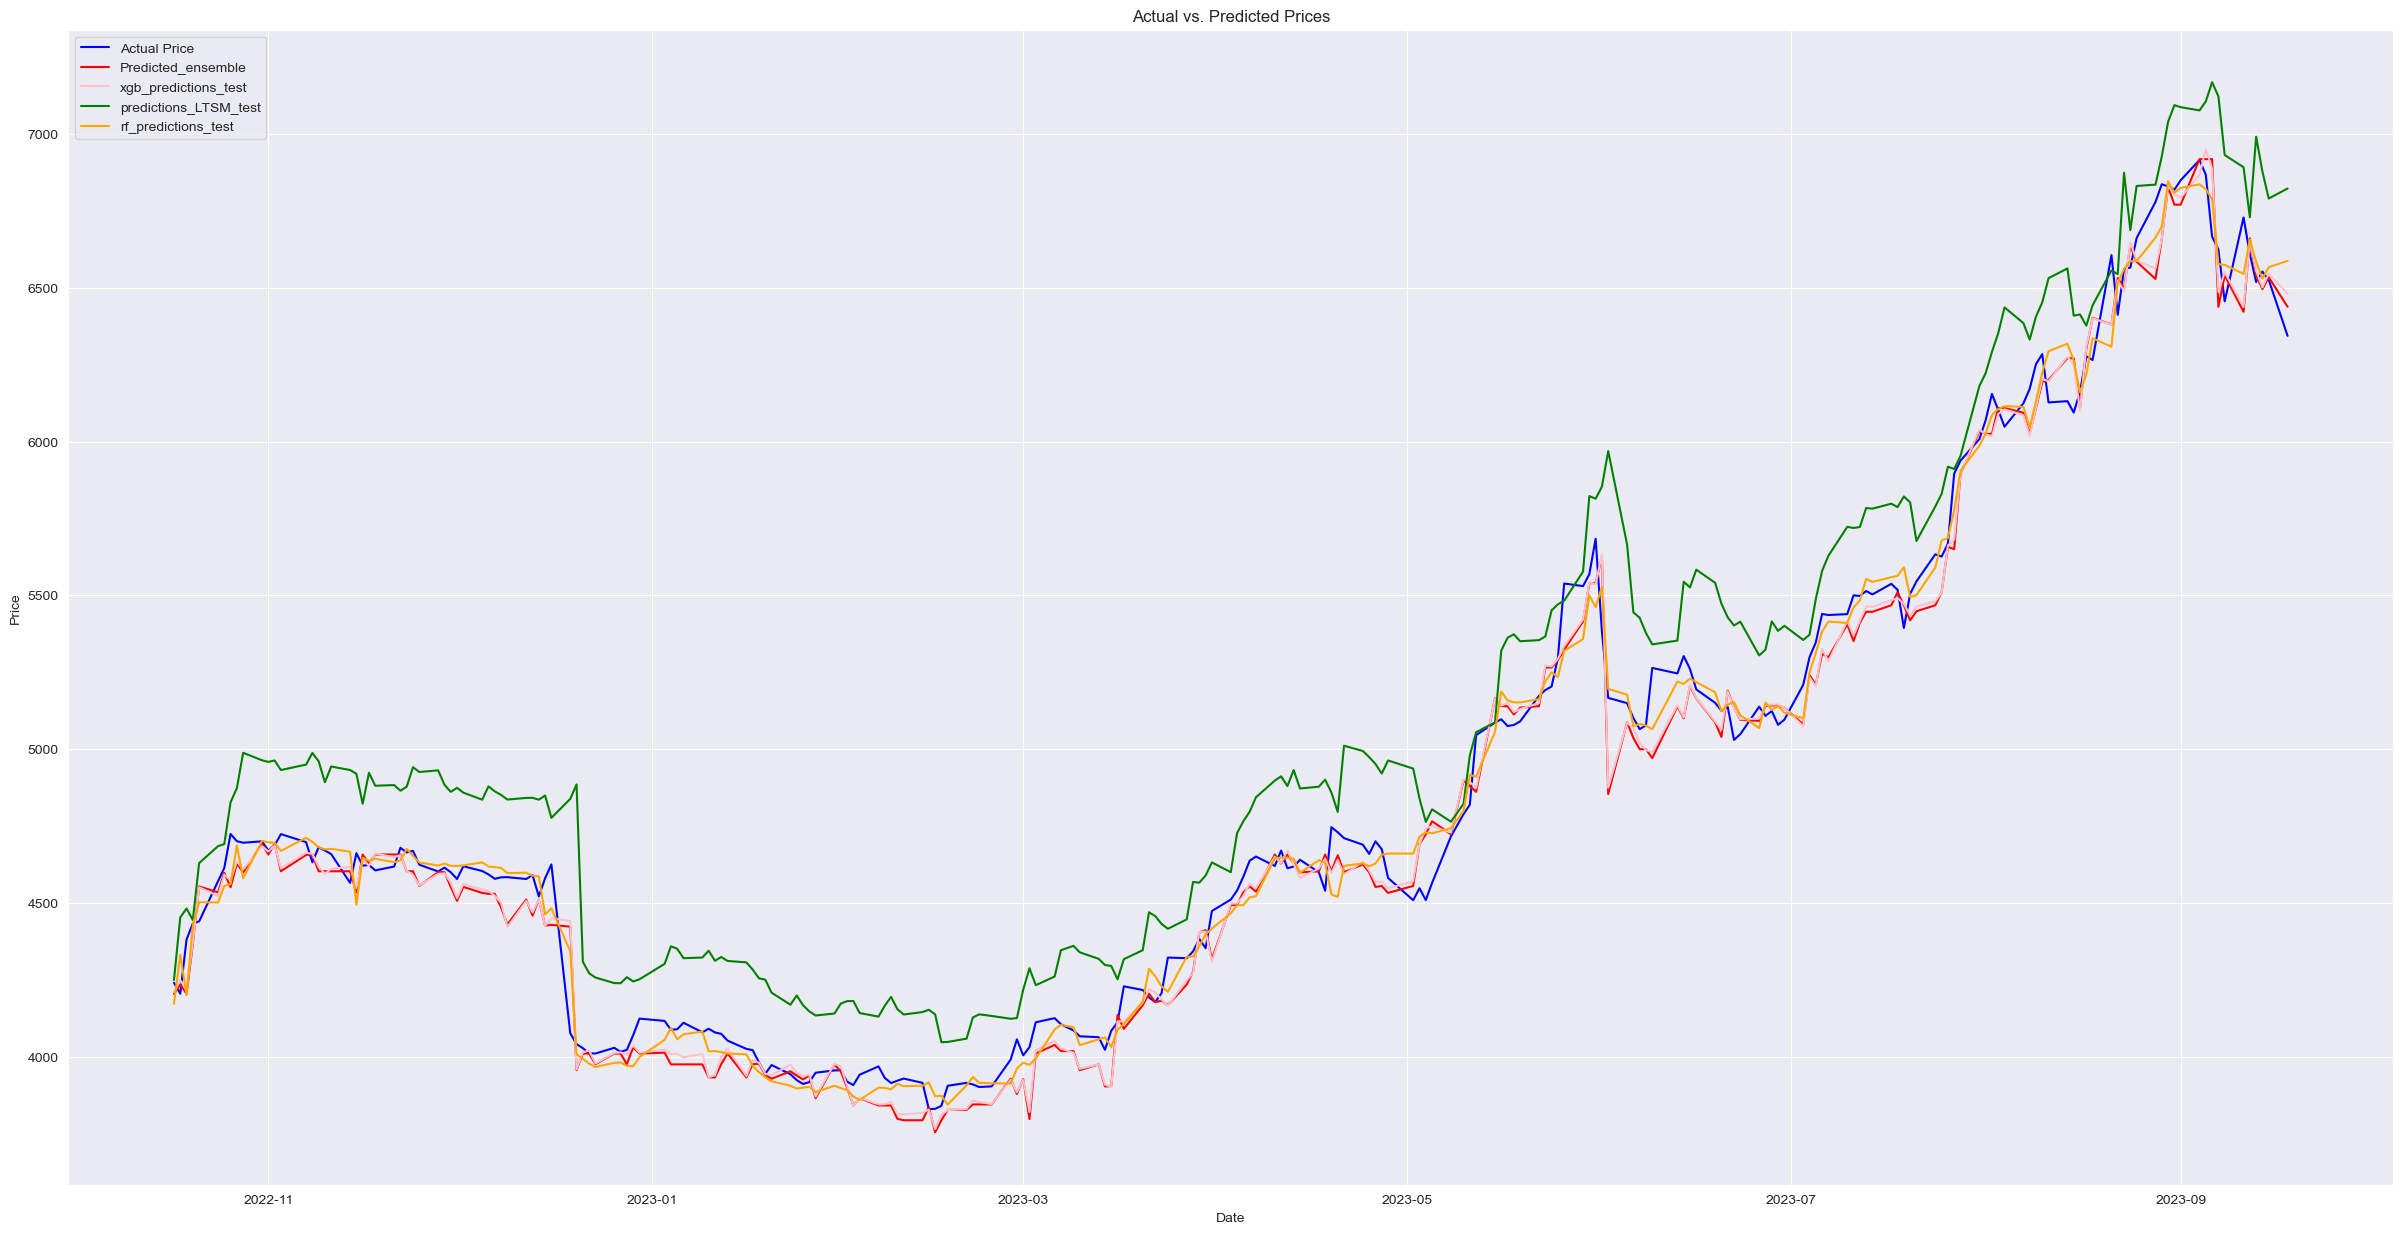

In [75]:
import matplotlib.pyplot as plt

# Reshape the arrays to be 1-dimensional
xgboost_ensemble_model_pred = np.reshape(xgboost_ensemble_model_pred, (-1,))
predictions_LTSM_test = np.reshape(predictions_LTSM_test, (-1,))
xgb_predictions_test = np.reshape(xgb_predictions_test, (-1,))
rf_predictions_test = np.reshape(rf_predictions_test, (-1,))

# Create DataFrame for visualization
results = pd.DataFrame({'Date':data_lkoh['Дата'][train_size+time_steps+1:], 'Actual': y_test, 'Predicted_ensemble': xgboost_ensemble_model_pred, 'predictions_LTSM_test': predictions_LTSM_test, 'xgb_predictions_test': xgb_predictions_test, 'rf_predictions_test': rf_predictions_test})

# Plot the graph
plt.figure(figsize=(30, 15))
plt.plot(results['Date'], results['Actual'], label='Actual Price', color='blue')
plt.plot(results['Date'], results['Predicted_ensemble'], label='Predicted_ensemble', color='red')
plt.plot(results['Date'], results['xgb_predictions_test'], label='xgb_predictions_test', color='pink')
plt.plot(results['Date'], results['predictions_LTSM_test'], label='predictions_LTSM_test', color='green')
plt.plot(results['Date'], results['rf_predictions_test'], label='rf_predictions_test', color='orange')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [597]:
results

,Date,Actual,Predicted_ensemble,predictions_LTSM_test,xgb_predictions_test,rf_predictions_test
2441,2022-10-17,4240.0,4169.353516,2219.764160,4164.327637,4177.050
2442,2022-10-18,4204.5,4145.786133,2218.154785,4143.939453,4168.120
2443,2022-10-19,4380.5,4193.925781,2218.566895,4182.761719,4167.570
2444,2022-10-20,4433.0,4145.786133,2253.020996,4145.017578,4149.520
2445,2022-10-21,4439.5,4193.925781,2264.115234,4198.450684,4145.935
...,...,...,...,...,...,...
2670,2023-09-12,6610.0,4474.419434,3620.296143,4482.770996,4359.030
2671,2023-09-13,6519.0,4525.863770,3585.261230,4528.462402,4360.155
2672,2023-09-14,6553.0,4525.863770,3567.401367,4529.170410,4369.720
2673,2023-09-15,6526.0,4525.863770,3559.287354,4535.042480,4362.970


In [598]:
data_lkoh['Дата'][train_size+time_steps+1:]

2441   2022-10-17
2442   2022-10-18
2443   2022-10-19
2444   2022-10-20
2445   2022-10-21
          ...    
2670   2023-09-12
2671   2023-09-13
2672   2023-09-14
2673   2023-09-15
2674   2023-09-18
Name: Дата, Length: 234, dtype: datetime64[ns]

In [599]:
xgboost_ensemble_model_pred

array([4169.3535, 4145.786 , 4193.926 , 4145.786 , 4193.926 , 4169.3535,
       4149.8105, 4169.3535, 4149.8105, 4193.926 , 4169.3535, 4169.3535,
       4193.926 , 4129.341 , 4169.3535, 4169.3535, 4193.926 , 4145.786 ,
       4193.926 , 4193.926 , 4169.3535, 4193.926 , 4145.786 , 4193.926 ,
       4169.3535, 4145.786 , 4169.3535, 4129.341 , 4193.926 , 4169.3535,
       4145.786 , 4169.3535, 4145.786 , 4216.8687, 4169.3535, 4169.3535,
       4169.3535, 4145.786 , 4193.926 , 4193.926 , 4169.3535, 4193.926 ,
       4169.3535, 4216.8687, 4169.3535, 4145.786 , 4193.926 , 4129.341 ,
       4193.926 , 4169.3535, 4169.3535, 4169.3535, 4129.341 , 4193.926 ,
       4788.1016, 4788.1016, 4755.923 , 4788.1016, 4754.9883, 4787.168 ,
       4787.168 , 4754.9883, 4788.1016, 4755.923 , 4788.1016, 4539.6924,
       4193.926 , 4216.8687, 4471.257 , 4483.122 , 4235.8457, 4193.926 ,
       4216.8687, 4471.257 , 4424.6895, 4788.1016, 4755.923 , 4788.1016,
       4755.923 , 4788.1016, 4787.168 , 4754.9883, 